In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

Используем метрику recall. Сейчас важнее выявить болезнь, чем не выявить.

Recall (Полнота) - отношение TP к TP + FN. Это то, какую долю объектов положительного класса из всех объектов положительного класса нашёл алгоритм.

# EDA

In [3]:
raw_path = '../data/raw/'
train = pd.read_csv(os.path.join(raw_path, 'train.csv'))
test = pd.read_csv(os.path.join(raw_path, 'test.csv'))

In [4]:
train.head()

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,...,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",ID_y,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,...,06:00:00,0,0,0,54-102-358-02,0,0,0,0,0
1,54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,...,04:00:00,1,0,0,54-103-101-01,1,1,0,0,0
2,54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,...,07:00:00,0,0,0,54-501-026-03,0,0,0,0,0
3,54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,...,07:00:00,0,0,0,54-501-094-02,1,0,0,0,0
4,54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,0,...,06:00:00,0,0,0,54-503-022-01,1,0,1,1,0


In [5]:
TARGET_COLS = ['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']
ID_COL = 'ID'
EDU_COL = 'Образование'
SEX_COL = 'Пол'
CAT_COLS = [
    'Пол', 'Семья', 'Этнос', 'Национальность', 'Религия', 'Образование', 
    'Профессия', 'Статус Курения', 'Алкоголь',
    'Время засыпания', 'Время пробуждения'
] 
OHE_COLS = [
    'Пол', 'Вы работаете?', 'Выход на пенсию', 'Прекращение работы по болезни', 'Сахарный диабет', 'Гепатит',
    'Онкология', 'Хроническое заболевание легких', 'Бронжиальная астма', 'Туберкулез легких ', 'ВИЧ/СПИД',
    'Регулярный прим лекарственных средств', 'Травмы за год', 'Переломы','Пассивное курение', 'Сон после обеда', 
    'Спорт, клубы', 'Религия, клубы'
]
REAL_COLS = ['Возраст курения', 'Сигарет в день', 'Возраст алког']

In [6]:
def set_idx(df: pd.DataFrame, idx_col: str) -> pd.DataFrame:
    df = df.set_index(idx_col)
    return df

In [7]:
train, target = train.drop(TARGET_COLS, axis=1), train[TARGET_COLS]

In [8]:
def drop_unnecesary_id(df: pd.DataFrame) -> pd.DataFrame:
    if 'ID_y' in df.columns:
        df = df.drop('ID_y', axis=1)
    return df

In [9]:
def add_ord_edu(df: pd.DataFrame) -> pd.DataFrame:
    df[f'{EDU_COL}_ord'] = df[EDU_COL].str.slice(0, 1).astype(np.int8).values
    return df

In [10]:
def fill_sex(df: pd.DataFrame) -> pd.DataFrame:
    most_freq = df[SEX_COL].value_counts().index[0]
    df[SEX_COL] = df[SEX_COL].fillna(most_freq)
    return df

In [11]:
def drop_nan_col(df: pd.DataFrame) -> pd.DataFrame:
    if 'Частота пасс кур' in df.columns:
        df = df.drop('Частота пасс кур', axis=1)
    return df

In [12]:
def cast_types(df: pd.DataFrame) -> pd.DataFrame:
    df[CAT_COLS] = df[CAT_COLS].astype('category')

    ohe_int_cols = train[OHE_COLS].select_dtypes('number').columns
    df[ohe_int_cols] = df[ohe_int_cols].astype(np.int8)

    df[REAL_COLS] = df[REAL_COLS].astype(np.float32)
    return df

In [13]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = set_idx(df, ID_COL)
    df = drop_unnecesary_id(df)
    df = drop_nan_col(df)
    # df = add_ord_edu(df)
    df = fill_sex(df)
    df = cast_types(df)
    return df

In [14]:
train = preprocess(train)
test = preprocess(test)

In [15]:
train.head() 

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,...,Возраст курения,Сигарет в день,Пассивное курение,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы"
ID,,,,,,,,,,,,,,,,,,,,,
54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,...,15.0,20.0,0,употребляю в настоящее время,18.0,22:00:00,06:00:00,0,0,0
54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,...,NaN,NaN,0,никогда не употреблял,NaN,00:00:00,04:00:00,1,0,0
54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,...,NaN,NaN,1,употребляю в настоящее время,17.0,23:00:00,07:00:00,0,0,0
54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,...,12.0,10.0,1,употребляю в настоящее время,13.0,23:00:00,07:00:00,0,0,0
54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,0,1,...,NaN,NaN,1,употребляю в настоящее время,16.0,23:00:00,06:00:00,0,0,0


In [16]:
pd.set_option('display.max_columns', None)

In [17]:
train.describe()

,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Возраст курения,Сигарет в день,Пассивное курение,Возраст алког,Сон после обеда,"Спорт, клубы","Религия, клубы"
count,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,412.000000,409.000000,955.000000,788.000000,955.000000,955.000000,955.000000
mean,0.523560,0.335079,0.048168,0.105759,0.120419,0.045026,0.075393,0.042932,0.020942,0.002094,0.642932,0.053403,0.353927,20.300970,14.220049,0.234555,20.038071,0.226178,0.068063,0.023037
std,0.499706,0.472265,0.214232,0.307690,0.325621,0.207470,0.264162,0.202810,0.143267,0.045739,0.479386,0.224954,0.478437,8.039847,10.154704,0.423942,5.177524,0.418575,0.251986,0.150098
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,6.000000,0.000000,17.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.000000,10.000000,0.000000,19.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,21.000000,20.000000,0.000000,20.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,58.000000,60.000000,1.000000,63.000000,1.000000,1.000000,1.000000


Проверим баланс классов

array([[<AxesSubplot:title={'center':'Артериальная гипертензия'}>,
        <AxesSubplot:title={'center':'ОНМК'}>],
       [<AxesSubplot:title={'center':'Стенокардия, ИБС, инфаркт миокарда'}>,
        <AxesSubplot:title={'center':'Сердечная недостаточность'}>],
       [<AxesSubplot:title={'center':'Прочие заболевания сердца'}>,
        <AxesSubplot:>]], dtype=object)

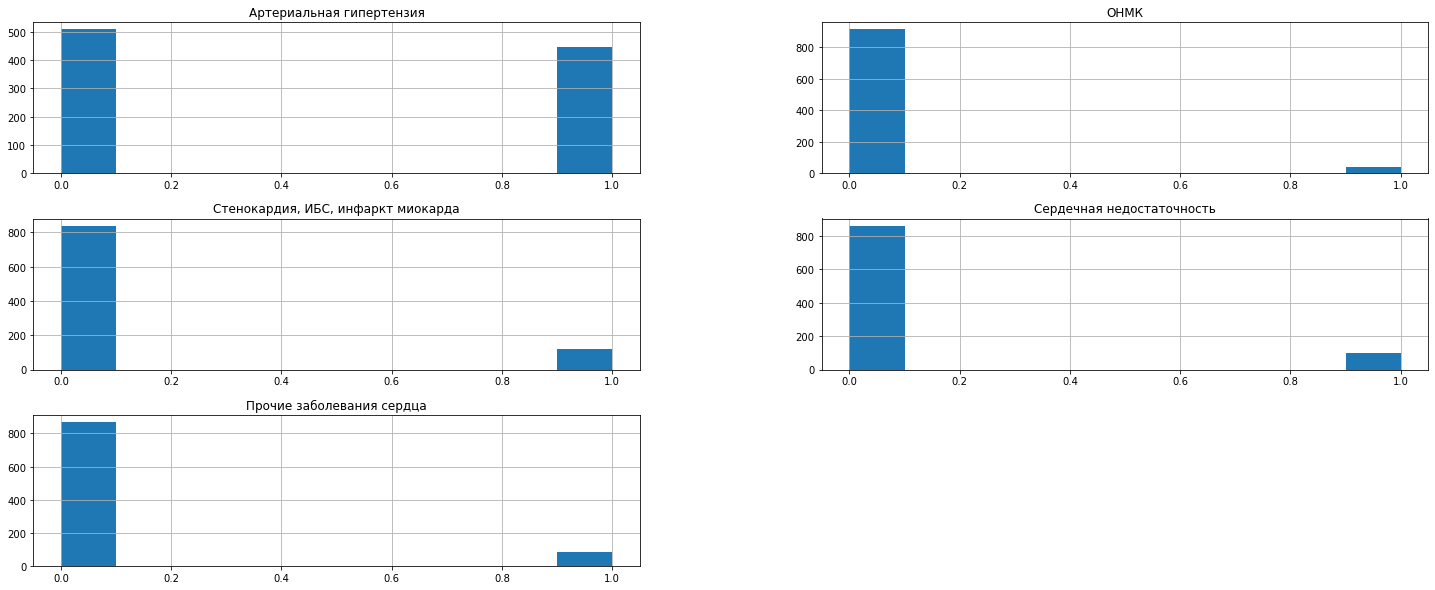

In [18]:
target.hist(figsize=(25,10))

In [19]:
for col in target.columns:
    print('Доля 1 класса в колонке {} - {}'.format(col, target[col].sum() / len(target[col])))
    print('Доля 0 класса в колонке {} - {}'.format(col, 1 - (target[col].sum() / len(target[col]))))

Доля 1 класса в колонке Артериальная гипертензия - 0.46701570680628274
Доля 0 класса в колонке Артериальная гипертензия - 0.5329842931937172
Доля 1 класса в колонке ОНМК - 0.04293193717277487
Доля 0 класса в колонке ОНМК - 0.9570680628272251
Доля 1 класса в колонке Стенокардия, ИБС, инфаркт миокарда - 0.1225130890052356
Доля 0 класса в колонке Стенокардия, ИБС, инфаркт миокарда - 0.8774869109947644
Доля 1 класса в колонке Сердечная недостаточность - 0.10052356020942409
Доля 0 класса в колонке Сердечная недостаточность - 0.8994764397905759
Доля 1 класса в колонке Прочие заболевания сердца - 0.09005235602094241
Доля 0 класса в колонке Прочие заболевания сердца - 0.9099476439790576


Почти везде (кроме "Артериальная гипертензия") данные несбалансированны. Это свойство для задач такого типа - больных людей как правило бывает меньше, чем здоровых

# CatBoost modeling

In [20]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from statistics import mean
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.model_selection import GridSearchCV

In [21]:
def replace_nans(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        
        nan_cols = df.columns[df.isna().any()].tolist()
        if col in nan_cols:
            if col not in REAL_COLS:
                most_frequent_value = df[col].value_counts().index[0]
                # df[col] = df[col].cat.add_categories(most_frequent_value)
                df[col] = df.fillna(most_frequent_value)
            else:
                mean_value = int(df[col].mean())
                # df[col] = df[col].cat.add_categories(mean_value)
                df[col].fillna(mean_value, inplace=True)

    return df

In [22]:
train = replace_nans(train)

In [23]:
train.head()

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы"
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,0,0,0,0,0,0,0,0,Курит,15.0,20.0,0,употребляю в настоящее время,18.0,22:00:00,06:00:00,0,0,0
54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,1,0,0,0,0,0,0,1,0,1,Никогда не курил(а),20.0,14.0,0,никогда не употреблял,20.0,00:00:00,04:00:00,1,0,0
54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),20.0,14.0,1,употребляю в настоящее время,17.0,23:00:00,07:00:00,0,0,0
54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,1,0,0,0,0,1,0,0,Бросил(а),12.0,10.0,1,употребляю в настоящее время,13.0,23:00:00,07:00:00,0,0,0
54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,0,1,1,1,0,0,0,0,0,1,0,1,Никогда не курил(а),20.0,14.0,1,употребляю в настоящее время,16.0,23:00:00,06:00:00,0,0,0


In [24]:
skf = StratifiedKFold(n_splits=5)

In [25]:
precision_recall_f1_cv = {
        'Артериальная гипертензия': [],
        'ОНМК': [],
        'Стенокардия, ИБС, инфаркт миокарда': [],
        'Сердечная недостаточность': [],
        'Прочие заболевания сердца': []
        }

for col in precision_recall_f1_cv.keys():
        for train_index, val_index in skf.split(train, target[col]):
                X_train, y_train = train.iloc[train_index], target[col].iloc[train_index]
                X_val, y_val = train.iloc[val_index], target[col].iloc[val_index]

                model = CatBoostClassifier(
                        learning_rate=0.001,
                        early_stopping_rounds=200,
                        verbose=100,
                        auto_class_weights='Balanced',
                        eval_metric='F1',
                        iterations=200,
                        )

                model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=CAT_COLS)
                y_pred = model.predict(X_val)
                precision_recall_f1_cv[col].append(precision_recall_fscore_support(y_val, y_pred, average='binary'))

0:	learn: 0.7631566	test: 0.7094517	best: 0.7094517 (0)	total: 205ms	remaining: 40.8s
100:	learn: 0.7626057	test: 0.7277477	best: 0.7307170 (1)	total: 2.78s	remaining: 2.72s
199:	learn: 0.7626057	test: 0.7277477	best: 0.7307170 (1)	total: 5.34s	remaining: 0us

bestTest = 0.7307169973
bestIteration = 1

Shrink model to first 2 iterations.
0:	learn: 0.7647095	test: 0.7410011	best: 0.7410011 (0)	total: 27.5ms	remaining: 5.48s
100:	learn: 0.7588142	test: 0.7410011	best: 0.7410011 (0)	total: 2.45s	remaining: 2.4s
199:	learn: 0.7588142	test: 0.7410011	best: 0.7410011 (0)	total: 5.03s	remaining: 0us

bestTest = 0.741001099
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.7556357	test: 0.7610855	best: 0.7610855 (0)	total: 20.7ms	remaining: 4.13s
100:	learn: 0.7540235	test: 0.7610855	best: 0.7610855 (0)	total: 2.59s	remaining: 2.54s
199:	learn: 0.7540235	test: 0.7610855	best: 0.7610855 (0)	total: 5.22s	remaining: 0us

bestTest = 0.7610855275
bestIteration = 0

Shrink model to 

In [26]:
all_precisions = []
all_recalls = []
all_f1s = []

for t in precision_recall_f1_cv.keys():
    mean_precision_of_target = mean([metrics[0] for metrics in precision_recall_f1_cv[t]])
    mean_recall_of_target = mean([metrics[1] for metrics in precision_recall_f1_cv[t]])
    mean_f1_of_target = mean([metrics[2] for metrics in precision_recall_f1_cv[t]])

    all_precisions.append(mean_precision_of_target)
    all_recalls.append(mean_recall_of_target)
    all_f1s.append(mean_f1_of_target)

Средние метрики по всем болезням на кросс-валидации

In [27]:
print(mean(all_precisions))
print(mean(all_recalls))
print(mean(all_f1s))

0.23456657306535347
0.7964986091386306
0.32641082010093336


Попробуем сделать tuning категориальных параметров в CatBoost

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train, target, train_size=0.8, random_state=RS)
X_train.shape, X_val.shape

In [280]:
best_estimator_gscv = {
        'Артериальная гипертензия': [],
        'ОНМК': [],
        'Стенокардия, ИБС, инфаркт миокарда': [],
        'Сердечная недостаточность': [],
        'Прочие заболевания сердца': []
        }

grid = {
        'one_hot_max_size': [3, 6, 10],
        'model_size_reg': [0, 0.2, 0.4, 0.6],
        'max_ctr_complexity': [2, 4, 6], 
        'ctr_leaf_count_limit': [1, 3, 6]
        }

for col in tqdm(best_estimator_gscv.keys()):
    model = CatBoostClassifier(learning_rate=0.001,early_stopping_rounds=200,
                                            verbose=100,
                                            auto_class_weights='Balanced',
                                            eval_metric='F1',
                                            cat_features=CAT_COLS,
                                            iterations=200) 

    grid_search = GridSearchCV(estimator = model, param_grid = grid, scoring ='recall', cv = 5)

    grid_search.fit(train, target[col])

    best_estimator_gscv[col].append(grid_search.best_estimator_)

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.7626057	total: 5.95ms	remaining: 1.18s
100:	learn: 0.7626057	total: 1.39s	remaining: 1.36s
199:	learn: 0.7626057	total: 2.68s	remaining: 0us
0:	learn: 0.7624458	total: 13.6ms	remaining: 2.71s
100:	learn: 0.7588142	total: 1.15s	remaining: 1.13s
199:	learn: 0.7588142	total: 2.45s	remaining: 0us
0:	learn: 0.7540235	total: 7.68ms	remaining: 1.53s
100:	learn: 0.7540235	total: 1.34s	remaining: 1.32s
199:	learn: 0.7540235	total: 2.71s	remaining: 0us
0:	learn: 0.7545430	total: 6.04ms	remaining: 1.2s
100:	learn: 0.7545430	total: 1.36s	remaining: 1.34s
199:	learn: 0.7545430	total: 2.61s	remaining: 0us
0:	learn: 0.7479959	total: 5.96ms	remaining: 1.19s
100:	learn: 0.7479959	total: 1.54s	remaining: 1.51s
199:	learn: 0.7479959	total: 2.91s	remaining: 0us
0:	learn: 0.7626057	total: 4.78ms	remaining: 952ms
100:	learn: 0.7626057	total: 1.41s	remaining: 1.38s
199:	learn: 0.7626057	total: 2.64s	remaining: 0us
0:	learn: 0.7624458	total: 14.6ms	remaining: 2.9s
100:	learn: 0.7588142	total: 1.27

In [287]:
for col in target.columns:
    print(best_estimator_gscv[col][0].get_params())

{'iterations': 200, 'learning_rate': 0.001, 'model_size_reg': 0, 'verbose': 100, 'ctr_leaf_count_limit': 1, 'max_ctr_complexity': 2, 'auto_class_weights': 'Balanced', 'one_hot_max_size': 6, 'eval_metric': 'F1', 'early_stopping_rounds': 200, 'cat_features': ['Пол', 'Семья', 'Этнос', 'Национальность', 'Религия', 'Образование', 'Профессия', 'Статус Курения', 'Алкоголь', 'Время засыпания', 'Время пробуждения']}
{'iterations': 200, 'learning_rate': 0.001, 'model_size_reg': 0.6, 'verbose': 100, 'ctr_leaf_count_limit': 3, 'max_ctr_complexity': 2, 'auto_class_weights': 'Balanced', 'one_hot_max_size': 6, 'eval_metric': 'F1', 'early_stopping_rounds': 200, 'cat_features': ['Пол', 'Семья', 'Этнос', 'Национальность', 'Религия', 'Образование', 'Профессия', 'Статус Курения', 'Алкоголь', 'Время засыпания', 'Время пробуждения']}
{'iterations': 200, 'learning_rate': 0.001, 'model_size_reg': 0.6, 'verbose': 100, 'ctr_leaf_count_limit': 1, 'max_ctr_complexity': 2, 'auto_class_weights': 'Balanced', 'one_ho

In [289]:
from collections import defaultdict

catboost_params = defaultdict(list)

for col in target.columns:
    estimator_params = best_estimator_gscv[col][0].get_params()

    for param in estimator_params.keys():
        catboost_params[param].append(estimator_params[param])

In [291]:
print(mean(catboost_params['model_size_reg']))
print(mean(catboost_params['ctr_leaf_count_limit']))
print(mean(catboost_params['max_ctr_complexity']))
print(mean(catboost_params['one_hot_max_size']))

0.42
1.4
2.8
6


In [28]:
skf = StratifiedKFold(n_splits=5)

In [29]:
precision_recall_f1_cv = {
        'Артериальная гипертензия': [],
        'ОНМК': [],
        'Стенокардия, ИБС, инфаркт миокарда': [],
        'Сердечная недостаточность': [],
        'Прочие заболевания сердца': []
        }

for col in precision_recall_f1_cv.keys():
        for train_index, val_index in skf.split(train, target[col]):
                X_train, y_train = train.iloc[train_index], target[col].iloc[train_index]
                X_val, y_val = train.iloc[val_index], target[col].iloc[val_index]

                model = CatBoostClassifier(
                        learning_rate=0.001,
                        early_stopping_rounds=200,
                        verbose=100,
                        auto_class_weights='Balanced',
                        eval_metric='F1',
                        iterations=200,
                        model_size_reg=0.42,
                        ctr_leaf_count_limit=1,
                        max_ctr_complexity=3,
                        one_hot_max_size=6
                        )

                model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=CAT_COLS)
                y_pred = model.predict(X_val)
                precision_recall_f1_cv[col].append(precision_recall_fscore_support(y_val, y_pred, average='binary'))

0:	learn: 0.7639293	test: 0.7124474	best: 0.7124474 (0)	total: 24.8ms	remaining: 4.93s
100:	learn: 0.7691811	test: 0.7277477	best: 0.7307769 (9)	total: 2.75s	remaining: 2.69s
199:	learn: 0.7691811	test: 0.7277477	best: 0.7307769 (9)	total: 5.56s	remaining: 0us

bestTest = 0.730776853
bestIteration = 9

Shrink model to first 10 iterations.
0:	learn: 0.7593600	test: 0.7346097	best: 0.7346097 (0)	total: 23.5ms	remaining: 4.68s
100:	learn: 0.7610888	test: 0.7477513	best: 0.7511727 (61)	total: 3.14s	remaining: 3.08s
199:	learn: 0.7596091	test: 0.7443609	best: 0.7511727 (61)	total: 5.6s	remaining: 0us

bestTest = 0.7511727453
bestIteration = 61

Shrink model to first 62 iterations.
0:	learn: 0.7617917	test: 0.7523551	best: 0.7523551 (0)	total: 21.2ms	remaining: 4.22s
100:	learn: 0.7548287	test: 0.7610855	best: 0.7674901 (6)	total: 2.58s	remaining: 2.52s
199:	learn: 0.7548287	test: 0.7610855	best: 0.7674901 (6)	total: 5.03s	remaining: 0us

bestTest = 0.7674900989
bestIteration = 6

Shrink mod

In [30]:
all_precisions = []
all_recalls = []
all_f1s = []

for t in precision_recall_f1_cv.keys():
    mean_precision_of_target = mean([metrics[0] for metrics in precision_recall_f1_cv[t]])
    mean_recall_of_target = mean([metrics[1] for metrics in precision_recall_f1_cv[t]])
    mean_f1_of_target = mean([metrics[2] for metrics in precision_recall_f1_cv[t]])

    all_precisions.append(mean_precision_of_target)
    all_recalls.append(mean_recall_of_target)
    all_f1s.append(mean_f1_of_target)

In [31]:
print(mean(all_precisions))
print(mean(all_recalls))
print(mean(all_f1s))

0.2563306281358416
0.760266367807504
0.35238058316753845


Подбор гиперпараметров помог увеличить f1 и precision, но не основную метрику - recall модели. Лучшей моделью на данный момент остается CatBoostClassifier(learning_rate=0.001,early_stopping_rounds=200, verbose=100, auto_class_weights='Balanced', eval_metric='F1')

С другой стороны, модель с подобранными параметрами адекватнее делает предсказания - она отправит на доп. обследование меньшее количество здоровых людей. Если пытаться максимизировать только recall, то стоит просто всех людей отправлять на доп. обследование

### Logistic Regression Modeling + OHE

Попробуем обучить Логистическую регрессию. Для этого необходимо обработать все категориальные переменные

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [33]:
TARGET_COLS = ['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']
ID_COL = 'ID'
EDU_COL = 'Образование'
SEX_COL = 'Пол'
CAT_COLS = [
    'Пол', 'Семья', 'Этнос', 'Национальность', 'Религия', 'Образование', 
    'Профессия', 'Статус Курения', 'Алкоголь',
    'Время засыпания', 'Время пробуждения'
] 
OHE_COLS = [
    'Пол', 'Вы работаете?', 'Выход на пенсию', 'Прекращение работы по болезни', 'Сахарный диабет', 'Гепатит',
    'Онкология', 'Хроническое заболевание легких', 'Бронжиальная астма', 'Туберкулез легких ', 'ВИЧ/СПИД',
    'Регулярный прим лекарственных средств', 'Травмы за год', 'Переломы','Пассивное курение', 'Сон после обеда', 
    'Спорт, клубы', 'Религия, клубы'
]
REAL_COLS = ['Возраст курения', 'Сигарет в день', 'Возраст алког']

In [34]:
processed_data_path = '../data/processed/'
train = pd.read_pickle(os.path.join(processed_data_path, 'train.pkl'))
target = pd.read_pickle(os.path.join(processed_data_path, 'target.pkl'))

In [35]:
def process_datetime(df: pd.DataFrame) -> pd.DataFrame:
    df['Время засыпания'] = pd.to_datetime(df['Время засыпания']).dt.hour
    df['Время пробуждения'] = pd.to_datetime(df['Время пробуждения']).dt.hour

    ind = df[df['Время засыпания']==0].index
    df.loc[ind,'Время засыпания'] = 24
    ind = df[df['Время засыпания']>=18].index
    df['AM_before'] = 0
    df.loc[ind,'AM_before'] = 1
    df['sleep_duration'] = 0
    df.loc[ind, 'sleep_duration'] = 24-df['Время засыпания']+df['Время пробуждения']
    ind = df[df['Время засыпания']<18].index
    df.loc[ind, 'sleep_duration'] = df['Время пробуждения']-df['Время засыпания']

    return df

In [36]:
train = process_datetime(train)

In [38]:
train = replace_nans(train)

In [39]:
train.shape

(955, 33)

In [40]:
def one_hot_encode(df: pd.DataFrame, ohe: OneHotEncoder) -> pd.DataFrame: 
    ohe_df = pd.DataFrame(ohe.transform(df[CAT_COLS]), index=df.index)
    ohe_df = ohe_df.astype(np.int8)
    return df.merge(ohe_df, left_index=True, right_index=True)

In [41]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(X_train[CAT_COLS])

In [42]:
train = one_hot_encode(train, OneHotEncoder(handle_unknown='ignore', sparse=False).fit(train[CAT_COLS]))

In [44]:
def normalize_real_cols(df: pd.DataFrame, scaler: MinMaxScaler) -> pd.DataFrame:
    x_scaled = scaler.transform(df[REAL_COLS])
    scaled_cols = pd.DataFrame(x_scaled, index=df.index, columns=['Возраст_курения_scaled', 'Сигарет_в_день_scaled', 'Возраст_алког_scaled'])
    
    return df.merge(scaled_cols, left_index=True, right_index=True)

In [45]:
train = normalize_real_cols(train, MinMaxScaler().fit(train[REAL_COLS]))

In [46]:
train.head()

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",AM_before,sleep_duration,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,Возраст_курения_scaled,Сигарет_в_день_scaled,Возраст_алког_scaled
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,0,0,0,0,0,0,0,0,Курит,15.0,20.0,0,употребляю в настоящее время,18.0,22,6,0,0,0,1,8,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.188679,0.322034,0.210526
54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,1,0,0,0,0,0,0,1,0,1,Никогда не курил(а),20.0,14.0,0,никогда не употреблял,20.0,24,4,1,0,0,1,4,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.283019,0.220339,0.245614
54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),20.0,14.0,1,употребляю в настоящее время,17.0,23,7,0,0,0,1,8,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.283019,0.220339,0.192982
54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,1,0,0,0,0,1,0,0,Бросил(а),12.0,10.0,1,употребляю в настоящее время,13.0,23,7,0,0,0,1,8,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.132075,0.152542,0.122807
54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,0,1,1,1,0,0,0,0,0,1,0,1,Никогда не курил(а),20.0,14.0,1,употребляю в настоящее время,16.0,23,6,0,0,0,1,7,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0.283019,0.220339,0.175439


In [47]:
X_train, X_val, y_train, y_val = train_test_split(train, target, train_size=0.8, random_state=42)

In [48]:
def log_reg_preprocess(df: pd.DataFrame, ohe: OneHotEncoder, scaler: MinMaxScaler) -> pd.DataFrame:
    df = process_datetime(df)
    df.info()
    df = one_hot_encode(df, ohe)
    df = normalize_real_cols(df, scaler)

    all_cols = df.columns
    log_reg_cols = list(set(all_cols) - set(['Время засыпания', 'Время пробуждения']) - set(cfg.REAL_COLS) - set(cfg.CAT_COLS))

    return df[log_reg_cols]

In [49]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(train[CAT_COLS])
scaler = MinMaxScaler().fit(train[REAL_COLS])

In [50]:
ALL_COLS = train.columns
LOG_REG_COLS = list(set(ALL_COLS) - set(['Время засыпания', 'Время пробуждения']) - set(REAL_COLS) - set(CAT_COLS))

In [51]:
train[LOG_REG_COLS].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,AM_before,29,30,31,32,Переломы,33,34,35,36,37,38,39,41,40,43,42,44,45,46,Туберкулез легких,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,Возраст_курения_scaled,Травмы за год,sleep_duration,Сигарет_в_день_scaled,Сон после обеда,Регулярный прим лекарственных средств,Выход на пенсию,28,Пассивное курение,Онкология,Прекращение работы по болезни,Гепатит,Вы работаете?,"Религия, клубы",Хроническое заболевание легких,"Спорт, клубы",Возраст_алког_scaled,ВИЧ/СПИД,Сахарный диабет,Бронжиальная астма
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54-102-358-02,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.188679,0,8,0.322034,0,0,0,0,0,0,0,0,1,0,0,0,0.210526,0,0,0
54-103-101-01,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.283019,0,4,0.220339,1,1,0,0,0,0,0,0,0,0,0,0,0.245614,0,1,0
54-501-026-03,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.283019,0,8,0.220339,0,1,0,0,1,0,0,0,0,0,0,0,0.192982,0,0,0
54-501-094-02,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.132075,0,8,0.152542,0,1,0,0,1,1,0,0,1,0,0,0,0.122807,0,0,0
54-503-022-01,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0.283019,0,7,0.220339,0,1,0,0,1,0,1,1,0,0,0,0,0.175439,0,1,0


In [52]:
skf = StratifiedKFold(n_splits=5)

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
models = []
precision_recall_f1_cv = {
        'Артериальная гипертензия': [],
        'ОНМК': [],
        'Стенокардия, ИБС, инфаркт миокарда': [],
        'Сердечная недостаточность': [],
        'Прочие заболевания сердца': []
        }

for col in precision_recall_f1_cv.keys():
        for train_index, val_index in skf.split(train[LOG_REG_COLS], target[col]):
                X_train, y_train = train[LOG_REG_COLS].iloc[train_index], target[col].iloc[train_index]
                X_val, y_val = train[LOG_REG_COLS].iloc[val_index], target[col].iloc[val_index]

                model = LogisticRegression(C=0.001, penalty='l2', solver='saga', l1_ratio=0.4,
                                        class_weight='balanced', n_jobs=-1, random_state=42,
                                        max_iter=300)

                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                precision_recall_f1_cv[col].append(precision_recall_fscore_support(y_val, y_pred, average='binary'))

In [55]:
all_precisions = []
all_recalls = []
all_f1s = []

for t in precision_recall_f1_cv.keys():
    mean_precision_of_target = mean([metrics[0] for metrics in precision_recall_f1_cv[t]])
    mean_recall_of_target = mean([metrics[1] for metrics in precision_recall_f1_cv[t]])
    mean_f1_of_target = mean([metrics[2] for metrics in precision_recall_f1_cv[t]])

    all_precisions.append(mean_precision_of_target)
    all_recalls.append(mean_recall_of_target)
    all_f1s.append(mean_f1_of_target)

In [56]:
print(mean(all_precisions))
print(mean(all_recalls))
print(mean(all_f1s))

0.2543953606180834
0.5948649026850775
0.32255121356018657


Логистическая регрессия на тестовых данных показала результат хуже. Попробуем другой алгоритм - LinearSVC

In [57]:
from sklearn import svm

In [58]:
model = svm.LinearSVC(class_weight='balanced')

grid_list = {"C": np.arange(1, 10, 1),
             "penalty": ['l1', 'l2'],
             'max_iter': np.arange(200, 1000, 200)}
 
grid_search = GridSearchCV(model, param_grid = grid_list, n_jobs = 4, cv = 3, scoring = 'recall') 
grid_search.fit(train[LOG_REG_COLS], target['ОНМК'])

GridSearchCV(cv=3, estimator=LinearSVC(class_weight='balanced'), n_jobs=4,
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_iter': array([200, 400, 600, 800]),
                         'penalty': ['l1', 'l2']},
             scoring='recall')

In [59]:
grid_search.best_estimator_

LinearSVC(C=2, class_weight='balanced', max_iter=600)

In [60]:
precision_recall_f1_cv = {
        'Артериальная гипертензия': [],
        'ОНМК': [],
        'Стенокардия, ИБС, инфаркт миокарда': [],
        'Сердечная недостаточность': [],
        'Прочие заболевания сердца': []
        }

for col in precision_recall_f1_cv.keys():
        for train_index, val_index in skf.split(train[LOG_REG_COLS], target[col]):
                X_train, y_train = train[LOG_REG_COLS].iloc[train_index], target[col].iloc[train_index]
                X_val, y_val = train[LOG_REG_COLS].iloc[val_index], target[col].iloc[val_index]

                model = svm.LinearSVC(class_weight='balanced')
                model.fit(X_train, y_train)

                y_pred = model.predict(X_val)

                precision_recall_f1_cv[col].append(precision_recall_fscore_support(y_val, y_pred, average='binary'))

In [61]:
all_precisions = []
all_recalls = []
all_f1s = []

for t in precision_recall_f1_cv.keys():
    mean_precision_of_target = mean([metrics[0] for metrics in precision_recall_f1_cv[t]])
    mean_recall_of_target = mean([metrics[1] for metrics in precision_recall_f1_cv[t]])
    mean_f1_of_target = mean([metrics[2] for metrics in precision_recall_f1_cv[t]])

    all_precisions.append(mean_precision_of_target)
    all_recalls.append(mean_recall_of_target)
    all_f1s.append(mean_f1_of_target)

In [62]:
print(mean(all_precisions))
print(mean(all_recalls))
print(mean(all_f1s))

0.24617392475502517
0.4977416580667355
0.3117960313341436


Лучше всех на кросс-валидации по метрике recall себя показала модель CatBoost. Оставим в проекте ее и Logistic Regression